In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/stats207

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 6.7 MB/s 
     |████████████████████████████████| 125 kB 58.5 MB/s 
     |████████████████████████████████| 512 kB 68.1 MB/s 
     |████████████████████████████████| 87 kB 7.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=25930d898d0d63b41579444a4338f3ce034dbf4203df9afc71072aec30ab1f36
  Stored in directory: /root/.cache/pip/wheels/1f/10/06/2a990ee4d73a8479fe2922445e8a876d38cfbfed052284c6a1
Successfully built fire


In [ ]:
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 7.8 MB/s 
     |████████████████████████████████| 33.8 MB 183 kB/s 
     |████████████████████████████████| 308 kB 39.8 MB/s 
     |████████████████████████████████| 209 kB 23.6 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 147 kB 32.6 MB/s 
     |████████████████████████████████| 112 kB 47.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=20fd13122bf267dc3f15cd6ba3e128b8f727286fde0dfe352b76c46a31b2d9f5
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling sc

In [ ]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# TimeSeriesDataset

In [ ]:
aqi_weekly = pd.read_csv('aqi_weekly_cleaned.csv')

In [ ]:
# add time index
aqi_weekly.reset_index(inplace=True)
aqi_weekly = aqi_weekly.rename(columns = {'index':'time_index'})
aqi_weekly.head()

time_index        week        aqi         co      ozone       pm25  \
0           0  2012-01-01  75.000000  16.428571  18.857143  75.000000   
1           1  2012-01-08  81.714286  17.714286  20.428571  81.714286   
2           2  2012-01-15  48.714286  11.428571  28.714286  48.142857   
3           3  2012-01-22  40.857143   7.714286  23.714286  39.428571   
4           4  2012-01-29  55.285714   8.857143  23.857143  55.285714   

         no2  
0  36.571429  
1  44.571429  
2  31.857143  
3  26.428571  
4  33.142857

In [ ]:
# add group id column 
aqi_weekly['group_id'] = 'aqi'

In [ ]:
aqi_weekly[:418].head() 

time_index        week        aqi         co      ozone       pm25  \
0           0  2012-01-01  75.000000  16.428571  18.857143  75.000000   
1           1  2012-01-08  81.714286  17.714286  20.428571  81.714286   
2           2  2012-01-15  48.714286  11.428571  28.714286  48.142857   
3           3  2012-01-22  40.857143   7.714286  23.714286  39.428571   
4           4  2012-01-29  55.285714   8.857143  23.857143  55.285714   

         no2 group_id  
0  36.571429      aqi  
1  44.571429      aqi  
2  31.857143      aqi  
3  26.428571      aqi  
4  33.142857      aqi

In [ ]:
aqi_weekly = aqi_weekly.drop(['week'], axis=1)
aqi_weekly.head()

time_index        aqi         co      ozone       pm25        no2 group_id
0           0  75.000000  16.428571  18.857143  75.000000  36.571429      aqi
1           1  81.714286  17.714286  20.428571  81.714286  44.571429      aqi
2           2  48.714286  11.428571  28.714286  48.142857  31.857143      aqi
3           3  40.857143   7.714286  23.714286  39.428571  26.428571      aqi
4           4  55.285714   8.857143  23.857143  55.285714  33.142857      aqi

In [ ]:
max_prediction_length = 1 # one-step forecast 
max_encoder_length = 5 # 'timesteps' 
training_cutoff = 417

training = TimeSeriesDataSet(
    aqi_weekly[lambda x: x.index <= training_cutoff],
    time_idx="time_index",
    target="aqi",
    group_ids=['group_id'],
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_index"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
       "aqi",
       "co", 
       "ozone", 
       "pm25", 
       "no2"
    ],
    target_normalizer=GroupNormalizer(
        groups=["group_id"]
    ),  # normalize by group; default is standard-scaling
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True, 
    allow_missing_timesteps=True
)

In [ ]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, aqi_weekly, min_prediction_idx=training_cutoff + 1)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
print(len(training), len(validation))
print(len(train_dataloader), len(val_dataloader))

413 104
12 1


In [ ]:
training[0]

({'x_cat': tensor([], size=(6, 0), dtype=torch.int64),
  'x_cont': tensor([[ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.7279e+00, -1.0000e+00,
            1.9473e+00,  2.4555e+00, -1.6060e+00,  2.2286e+00,  1.5034e+00],
          [ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.7196e+00, -8.0000e-01,
            2.4316e+00,  2.8418e+00, -1.4706e+00,  2.6728e+00,  2.4822e+00],
          [ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.7113e+00, -6.0000e-01,
            5.1419e-02,  9.5317e-01, -7.5686e-01,  4.5184e-01,  9.2660e-01],
          [ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.7031e+00, -4.0000e-01,
           -5.1528e-01, -1.6287e-01, -1.1876e+00, -1.2467e-01,  2.6239e-01],
          [ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.6948e+00, -2.0000e-01,
            5.2539e-01,  1.8053e-01, -1.1753e+00,  9.2438e-01,  1.0839e+00],
          [ 1.0000e+00,  0.0000e+00, -1.7764e-15, -1.6865e+00,  0.0000e+00,
            2.6780e-01,  2.6638e-01, -7.1995e-01,  6.0305e-01,  1.0490e+00]]),
  'encoder_leng

# Train

## TODO: Find Optimal Learning Rate


In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

INFO:lightning_lite.utilities.seed:Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
/usr/local/lib/python3.7/dist-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 21.5k


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property calle

In [ ]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:97: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/stats207/.lr_find_5f2ec92e-9ce3-489b-92a5-74a0470d5562.ckpt


KeyError: ignored

## Train Model 

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 21.5k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# TODO: Hyperparameter Tuning

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
[I 2022-11-29 19:09:29,225] A new study created in memory with name: no-name-2aaed3d5-650a-4708-968e-fcbc733b7e92
[W 2022-11-29 19:09:29,232] Trial 0 fai

TypeError: ignored

# Evaluate

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

tensor(10.1873)

In [ ]:
print(len(actuals), len(predictions)) 

104 104


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

def calculate_metrics(pred, actual, verbose=True ):
    result_metrics = {'mae' : mean_absolute_error(pred, actual),
                      'mape' : mean_absolute_percentage_error(pred, actual),
                      'mse' : mean_squared_error(pred, actual), 
                      'rmse' : mean_squared_error(pred, actual) ** 0.5
                      }
    
    if verbose:
      print("Mean Absolute Error:       ", result_metrics["mae"])
      print("Mean Absolute Percentage Error:       ", result_metrics["mape"])
      print("Mean Squared Error:   ", result_metrics["mse"])
      print("Root Mean Squared Error:   ", result_metrics["rmse"])
      
    return result_metrics

In [ ]:
metrics = calculate_metrics(predictions, actuals)

Mean Absolute Error:        10.187287
Mean Absolute Percentage Error:        0.21274461
Mean Squared Error:    259.06342
Root Mean Squared Error:    16.095447043413976


In [ ]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

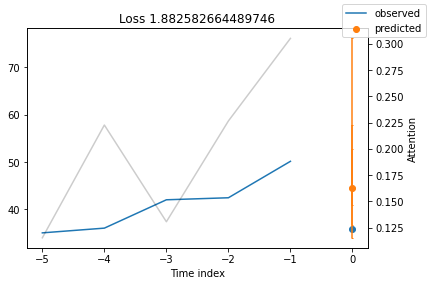

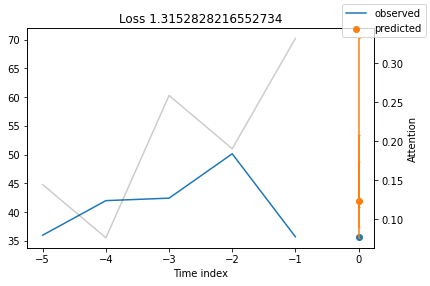

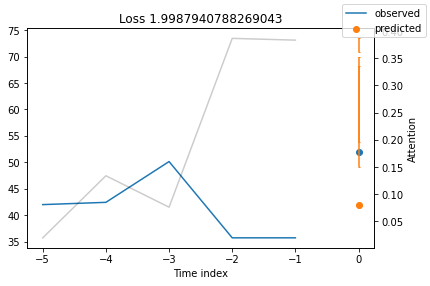

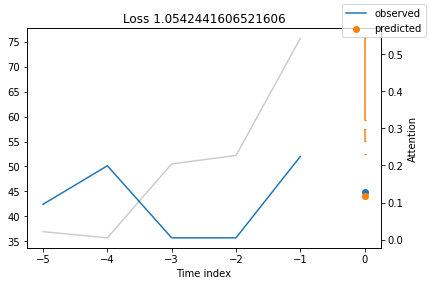

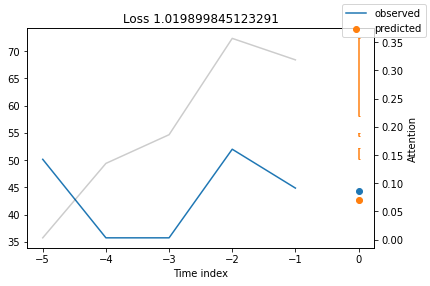

In [ ]:
# The grey lines denote the amount of attention the model pays to different points in time when making the prediction.
# This is a special feature of the Temporal Fusion Transformer.
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## Actuals vs Predictions by Variables

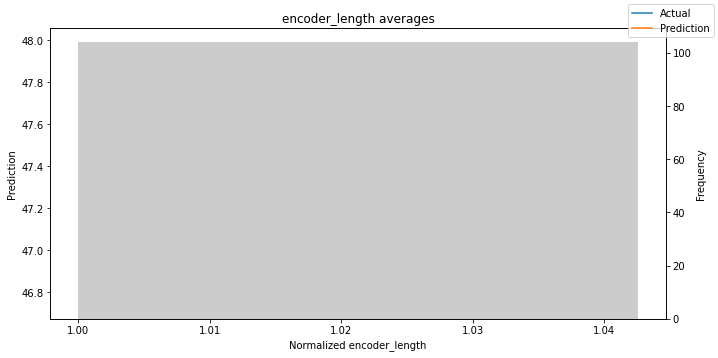

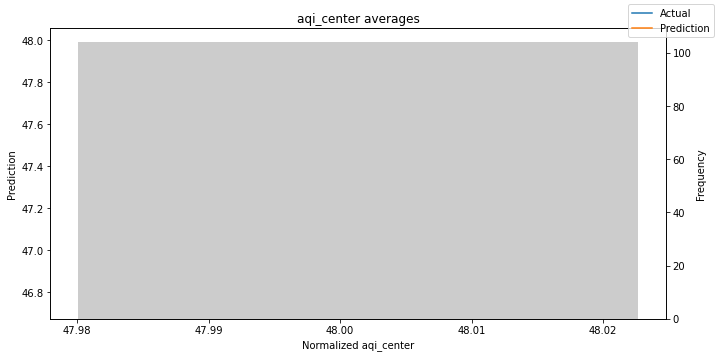

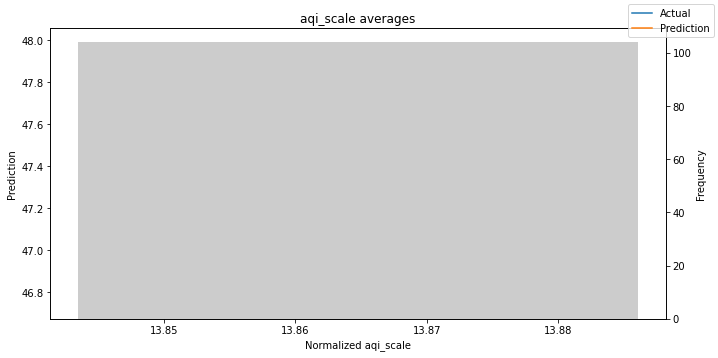

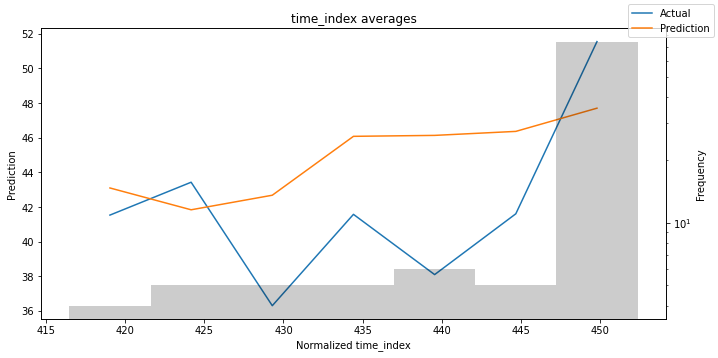

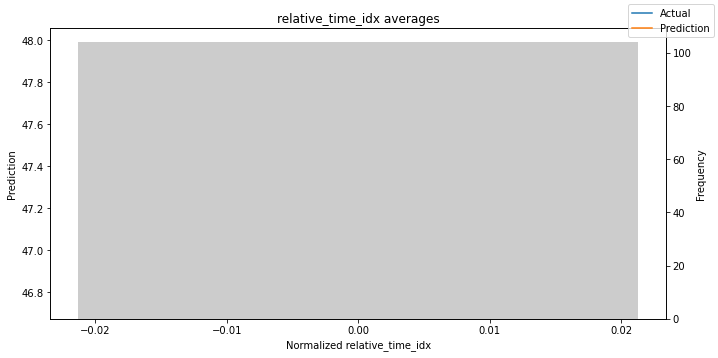

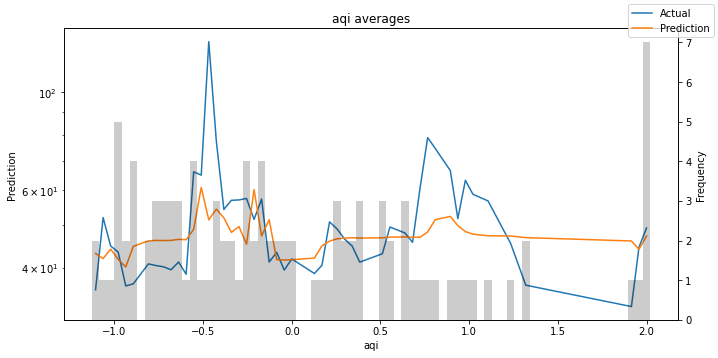

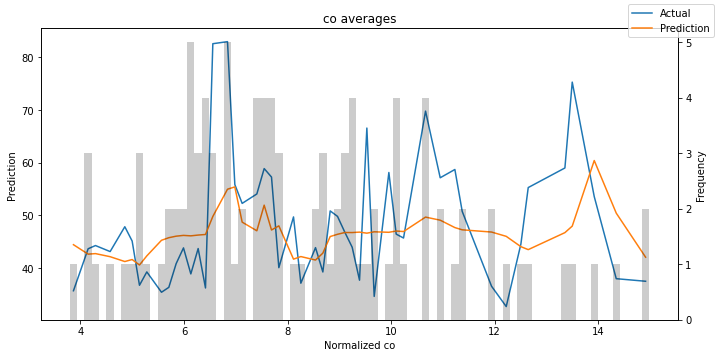

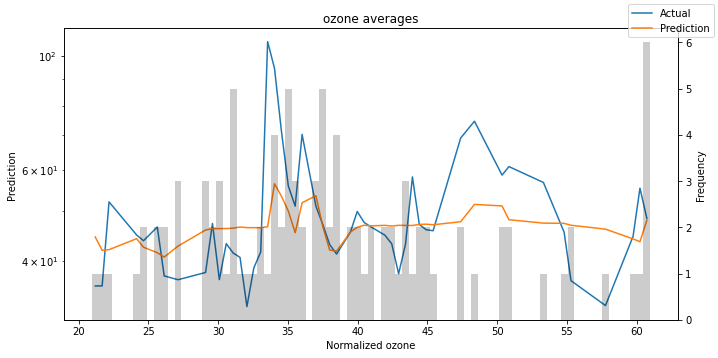

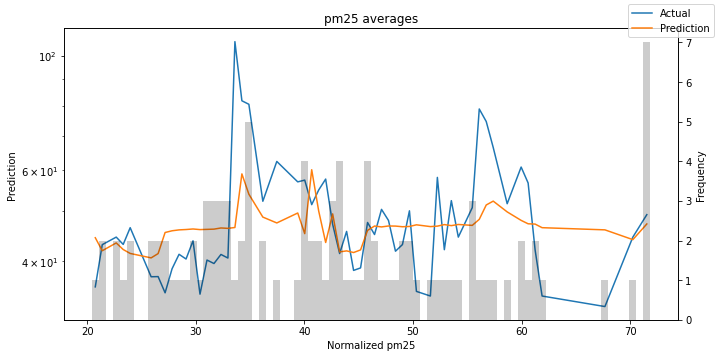

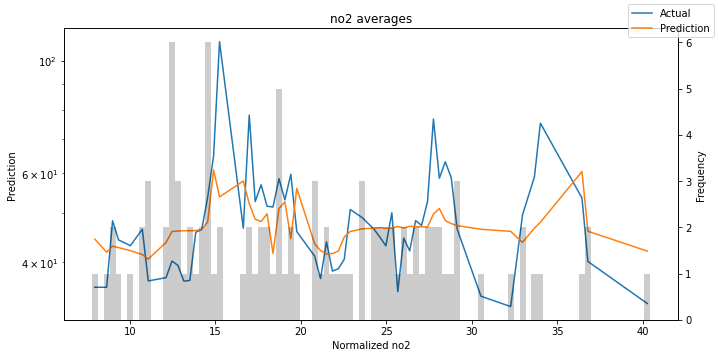

In [ ]:
# means of predictions vs actuals across each variable divided into 100 bins
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

# Interpret Model

## Variable Importances

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x198 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x180 with 1 Axes>}

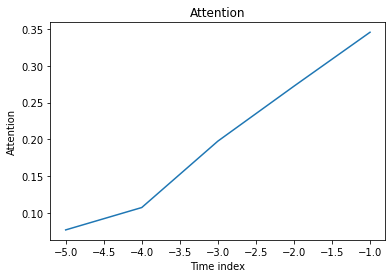

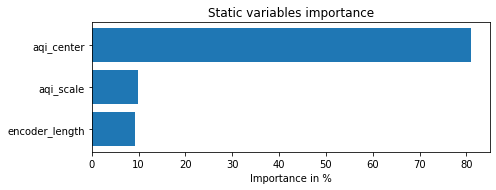

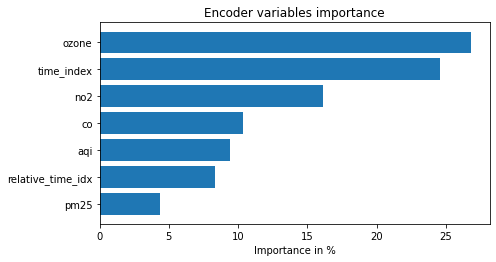

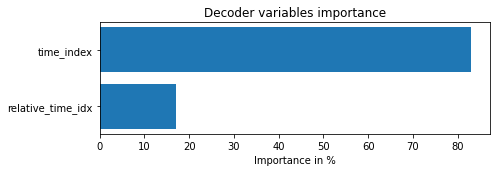

In [ ]:
# Ozone is the top variable in the encoder??
# The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. 
# The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

## TODO: Partial Dependency

In [ ]:
# Partial dependency plots are often used to interpret the model better (assuming independence of features).
# They can be also useful to understand what to expect in case of simulations
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "no2", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid 

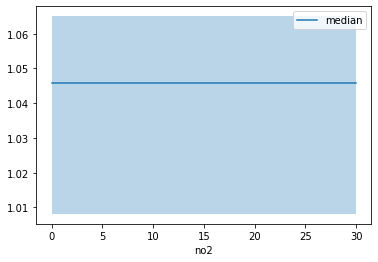

In [ ]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("no2").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);

# Hyperparameter Tuning

In [ ]:
max_prediction_length = 1 # one-step forecast 
training_cutoff = 417

In [ ]:
# Hyperaparameters
timesteps = [1, 3, 5, 7, 10, 14]
learning_rates=[0.001,0.01,0.1]
hidden_size=[16, 32, 64, 128]
attention_head_size=[1, 2, 3]
dropout=[0.1, 0.3, 0.5]
hidden_continuous_size=[8]

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
/usr/local/lib/python3.8/dist-packages/lightning_lite/accelerators/cuda.py:159: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
errors_df = pd.DataFrame()

for t in timesteps:  
  max_encoder_length = t

  training = TimeSeriesDataSet(
      aqi_weekly[lambda x: x.index <= training_cutoff],
      time_idx="time_index",
      target="aqi",
      group_ids=['group_id'],
      max_encoder_length=max_encoder_length,
      min_prediction_length=1,
      max_prediction_length=max_prediction_length,
      time_varying_known_reals=["time_index"],
      time_varying_unknown_categoricals=[],
      time_varying_unknown_reals=[
        "aqi",
        "co", 
        "ozone", 
        "pm25", 
        "no2"
      ],
      target_normalizer=GroupNormalizer(
          groups=["group_id"]
      ),  # normalize by group; default is standard-scaling
      add_relative_time_idx=True,
      add_target_scales=True,
      add_encoder_length=True, 
      allow_missing_timesteps=True
  )

  validation = TimeSeriesDataSet.from_dataset(training, aqi_weekly, min_prediction_idx=training_cutoff + 1)

  batch_size = 32  
  train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
  val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

  for lr in learning_rates:
    for h in hidden_size:
      for a in attention_head_size:
        for d in dropout:
          params = { 'timesteps': t, 'learning_rate': lr, 'dropout': d,
                      'hidden_dim': h, 'attention_head': a}
          # print(params)
          tft = TemporalFusionTransformer.from_dataset(
              training,
              learning_rate=lr,
              hidden_size=h,
              attention_head_size=a,
              dropout=d,
              hidden_continuous_size=8,
              output_size=7,  # 7 quantiles by default
              loss=QuantileLoss(),
              log_interval=10, 
              reduce_on_plateau_patience=4,
          )

          trainer.fit(
              tft,
              train_dataloaders=train_dataloader,
              val_dataloaders=val_dataloader,
          )

          best_model_path = trainer.checkpoint_callback.best_model_path
          best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

          actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
          predictions = best_tft.predict(val_dataloader)

          
          metrics = calculate_metrics(predictions, actuals, verbose=False)
          out_dict = {**params,  **metrics}
          errors_df = errors_df.append(out_dict, ignore_index=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
errors_df = errors_df.sort_values(by="rmse")
errors_df.to_csv('TFT_weekly_metrics.csv')
errors_df.head(30)

timesteps  learning_rate  dropout  hidden_dim  attention_head        mae  \
134        3.0          0.001      0.5        64.0             3.0  10.506805   
138        3.0          0.001      0.1       128.0             2.0  10.506805   
139        3.0          0.001      0.3       128.0             2.0  10.506805   
140        3.0          0.001      0.5       128.0             2.0  10.506805   
141        3.0          0.001      0.1       128.0             3.0  10.506805   
142        3.0          0.001      0.3       128.0             3.0  10.506805   
143        3.0          0.001      0.5       128.0             3.0  10.506805   
144        3.0          0.010      0.1        16.0             1.0  10.506805   
145        3.0          0.010      0.3        16.0             1.0  10.506805   
146        3.0          0.010      0.5        16.0             1.0  10.506805   
147        3.0          0.010      0.1        16.0             2.0  10.506805   
148        3.0          0.010      0.3        16.0             2.0  10.506805   
149        3.0          0.010      0.5        16.0             2.0  10.506805   
150        3.0          0.010      0.1        16.0             3.0  10.506805   
151        3.0          0.010      0.3        16.0             3.0  10.506805   
152        3.0          0.010      0.5        16.0             3.0  10.506805   
153        3.0          0.010      0.1        32.0             1.0  10.506805   
154        3.0          0.010      0.3        32.0             1.0  10.506805   
155        3.0          0.010      0.5        32.0             1.0  10.506805   
156        3.0          0.010      0.1        32.0             2.0  10.506805   
157        3.0          0.010      0.3        32.0             2.0  10.506805   
158        3.0          0.010      0.5        32.0             2.0  10.506805   
159        3.0          0.010      0.1        32.0             3.0  10.506805   
160        3.0          0.010      0.3        32.0             3.0  10.506805   
137        3.0          0.001      0.5       128.0             1.0  10.506805   
161        3.0          0.010      0.5        32.0             3.0  10.506805   
136        3.0          0.001      0.3       128.0             1.0  10.506805   
133        3.0          0.001      0.3        64.0             3.0  10.506805   
110        3.0          0.001      0.5        16.0             1.0  10.506805   
111        3.0          0.001      0.1        16.0             2.0  10.506805   

         mape         mse       rmse  
134  0.229003  291.469452  17.072476  
138  0.229003  291.469452  17.072476  
139  0.229003  291.469452  17.072476  
140  0.229003  291.469452  17.072476  
141  0.229003  291.469452  17.072476  
142  0.229003  291.469452  17.072476  
143  0.229003  291.469452  17.072476  
144  0.229003  291.469452  17.072476  
145  0.229003  291.469452  17.072476  
146  0.229003  291.469452  17.072476  
147  0.229003  291.469452  17.072476  
148  0.229003  291.469452  17.072476  
149  0.229003  291.469452  17.072476  
150  0.229003  291.469452  17.072476  
151  0.229003  291.469452  17.072476  
152  0.229003  291.469452  17.072476  
153  0.229003  291.469452  17.072476  
154  0.229003  291.469452  17.072476  
155  0.229003  291.469452  17.072476  
156  0.229003  291.469452  17.072476  
157  0.229003  291.469452  17.072476  
158  0.229003  291.469452  17.072476  
159  0.229003  291.469452  17.072476  
160  0.229003  291.469452  17.072476  
137  0.229003  291.469452  17.072476  
161  0.229003  291.469452  17.072476  
136  0.229003  291.469452  17.072476  
133  0.229003  291.469452  17.072476  
110  0.229003  291.469452  17.072476  
111  0.229003  291.469452  17.072476